In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Pystruct

## Structured Prediction!

Test score with chain CRF: 0.786840
Test score with linear SVM: 0.713791


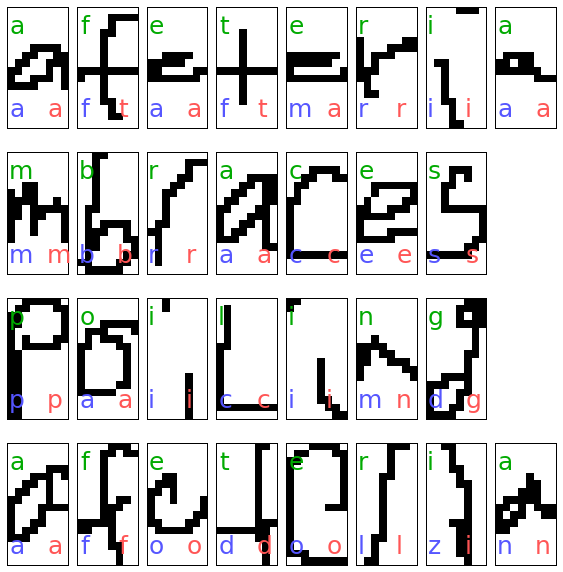

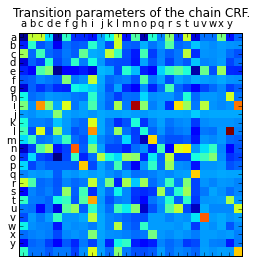

In [3]:
# %load ../pystruct/examples/plot_letters.py
"""
===============================
OCR Letter sequence recognition
===============================
This example illustrates the use of a chain CRF for optical character
recognition. The example is taken from Taskar et al "Max-margin markov random
fields".

Each example consists of a handwritten word, that was presegmented into
characters.  Each character is represented as a 16x8 binary image. The task is
to classify the image into one of the 26 characters a-z. The first letter of
every word was ommited as it was capitalized and the task does only consider
small caps letters.

We compare classification using a standard linear SVM that classifies
each letter individually with a chain CRF that can exploit correlations
between neighboring letters (the correlation is particularly strong
as the same words are used during training and testsing).

The first figures shows the segmented letters of four words from the test set.
In set are the ground truth (green), the prediction using SVM (blue) and the
prediction using a chain CRF (red).

The second figure shows the pairwise potentials learned by the chain CRF.
The strongest patterns are "y after l" and "n after i".

There are obvious extensions that both methods could benefit from, such as
window features or non-linear kernels. This example is more meant to give a
demonstration of the CRF than to show its superiority.
"""
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC

from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

abc = "abcdefghijklmnopqrstuvwxyz"

letters = load_letters()
X, y, folds = letters['data'], letters['labels'], letters['folds']
# we convert the lists to object arrays, as that makes slicing much more
# convenient
X, y = np.array(X), np.array(y)
X_train, X_test = X[folds == 1], X[folds != 1]
y_train, y_test = y[folds == 1], y[folds != 1]

# Train linear SVM
svm = LinearSVC(dual=False, C=.1)
# flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

# Train linear chain CRF
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=11)
ssvm.fit(X_train, y_train)

print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

print("Test score with linear SVM: %f" % svm.score(np.vstack(X_test),
                                                   np.hstack(y_test)))

# plot some word sequenced
n_words = 4
rnd = np.random.RandomState(1)
selected = rnd.randint(len(y_test), size=n_words)
max_word_len = max([len(y_) for y_ in y_test[selected]])
fig, axes = plt.subplots(n_words, max_word_len, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
for ind, axes_row in zip(selected, axes):
    y_pred_svm = svm.predict(X_test[ind])
    y_pred_chain = ssvm.predict([X_test[ind]])[0]
    for i, (a, image, y_true, y_svm, y_chain) in enumerate(
            zip(axes_row, X_test[ind], y_test[ind], y_pred_svm, y_pred_chain)):
        a.matshow(image.reshape(16, 8), cmap=plt.cm.Greys)
        a.text(0, 3, abc[y_true], color="#00AA00", size=25)
        a.text(0, 14, abc[y_svm], color="#5555FF", size=25)
        a.text(5, 14, abc[y_chain], color="#FF5555", size=25)
        a.set_xticks(())
        a.set_yticks(())
    for ii in range(i + 1, max_word_len):
        axes_row[ii].set_visible(False)

plt.matshow(ssvm.w[26 * 8 * 16:].reshape(26, 26))
plt.title("Transition parameters of the chain CRF.")
plt.xticks(np.arange(25), abc)
plt.yticks(np.arange(25), abc)
plt.show()
